<a href="https://colab.research.google.com/github/tikendraw/question-answering-squad-model/blob/main/question_answers_genration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answers Generations Model

In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/question-answer-generation.git 
    os.chdir('question-answer-generation') 
    print(os.getcwd())

Cloning into 'question-answer-generation'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 52 (delta 19), reused 27 (delta 7), pack-reused 0
Unpacking objects: 100% (52/52), 20.69 MiB | 5.33 MiB/s, done.
/content/question-answer-generation


In [2]:
# Dependencies
!pip install tensorflow-text
import tensorflow_text as tf_text

import pandas as pd
! pip install polars
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, Input, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tensorflow_hub
import tensorflow_hub as hub
import os
import re
import json

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)
    print(config)

def download_USEncoder():

    print('downloading universal sentence encoder...')
    !wget https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
    print('Downloaded universal sentence encoder.')
    # Extracting
    try:
        !mkdir universal_sentence_encoder
        print('Extracting universal sentence encoder....')
        ! tar -xf 4.tar.gz --directory ./universal_sentence_encoder
        print('Extracted.')
    except Exception as e:
        print(e)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

In [5]:
%run squad_preprocessing.py

In [32]:
# get the data
df = pl.read_csv('dataset/train_data_cleaned.csv')
df.shape,  type(df)

((86821, 11), polars.internals.dataframe.frame.DataFrame)

In [33]:
df.sample(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start
i64,str,str,str,str,str,bool,i64,str,str,i64
121359,"""University""","""There are seve...","""573196f9e99e30...","""What kind of s...","""[{'text': 'for...",false,1,"""{'text': 'fore...","""foreign studen...",292
40149,"""Macintosh""","""In 1987, Apple...","""570d1089b3d812...","""Which series o...","""[{'text': '""Pr...",false,1,"""{'text': '""Pro...","""""Pro"" series""",256
30085,"""House_music""","""In the early 1...","""57069b2452bb89...","""what style of ...","""[{'text': 'B-B...",false,1,"""{'text': 'B-Bo...","""B-Boy hip hop ...",285
85018,"""European_Centr...","""In contrast to...","""57281a83ff5b50...","""What is the ma...","""[{'text': 'rep...",false,1,"""{'text': 'repu...","""repurchase agr...",271
129945,"""Kathmandu""","""Kathmandu is h...","""5735c028e85393...","""Along with Bud...","""[{'text': 'Hin...",false,1,"""{'text': 'Hind...","""Hinduism""",214


In [34]:
# null check
df.null_count()

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


In [35]:
#drop nulls
df.drop_nulls()
print('Null removed')

Null removed


I would like to add the `title` column to `context` . there will a columns less to process.

In [36]:
df = df.with_columns(
    (pl.col('title') + '  ' +pl.col('context')).alias('newcontext')
)

In [37]:
df = df.with_columns([
    (pl.col("context").apply(lambda x: len(str(x).split(' '))).alias("context_len")),
    (pl.col("newcontext").apply(lambda x: len(str(x).split(' '))).alias("newcontext_len")),
    (pl.col("questions").apply(lambda x: len(str(x).split(' '))).alias("question_len")),
    (pl.col("answer_text").apply(lambda x: len(str(x).split(' '))).alias("answer_len"))])

In [38]:
df.sample(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
35873,"""Videoconferenc...","""Technological ...","""570af6876b8089...","""In what decade...","""[{'text': 'the...",false,1,"""{'text': 'the ...","""the 2010s""",62,"""Videoconferenc...",99,101,13,2
119949,"""Indigenous_peo...","""Indigenous gen...","""5731295f05b4da...","""How many years...","""[{'text': '10–...",false,1,"""{'text': '10–2...","""10–20,000 year...",237,"""Indigenous_peo...",80,82,12,2
125309,"""Financial_cris...","""The pricing of...","""57334ed54776f4...","""What is a meas...","""[{'text': 'int...",false,1,"""{'text': 'inte...","""interest rates...",137,"""Financial_cris...",85,87,8,4
68624,"""Crimean_War""","""In August 1855...","""572714e2dd62a8...","""What was capta...","""[{'text': 'ent...",false,1,"""{'text': 'entr...","""entrance to th...",434,"""Crimean_War I...",109,111,7,4
111666,"""Premier_League...","""The Premier Le...","""5733f6204776f4...","""What is said t...","""[{'text': 'the...",false,1,"""{'text': 'the ...","""the gap""",495,"""Premier_League...",149,151,21,2


# Dataset Analysis

In [39]:
#plotting a verticle axis for 95% mark
def dist_info(x, r:tuple = (90,100), bins:int = 100, title = 'old', xlim:list = None, ylim:list = None):
    
    '''
    this function plot distribution of series with axis lines with given range.
    
    x : series  = series of numbers
    r : tuple   =  tuple with low and high values to plot
    title : str =  title of the plot
    xlim : list = low and high limit to limit the plot
    ylim : list = similar to xlim
    '''
    
    print('Percent  ::   words  \n')
    plt.figure(figsize = (25,5))
    sns.histplot(x = x, bins = bins)

    for percent in range(r[0], r[1]+1):
        perc_x = np.percentile(x, percent)
        print(f'{percent:6}%  ::   {perc_x} words') 
        plt.axvline(x = perc_x, color = 'red')
        plt.text(x = perc_x, y = 2500+np.random.randint(100, 400), s = f'{percent}%')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title =='old':
        plt.title(f'Length Distribution of {x.name}')
    else:
        plt.title(str(title))
    # plt.show()


## 1. Context

Percent  ::   words  

    95%  ::   215.0 words
    96%  ::   224.0 words
    97%  ::   236.0 words
    98%  ::   254.0 words
    99%  ::   285.0 words
   100%  ::   655.0 words


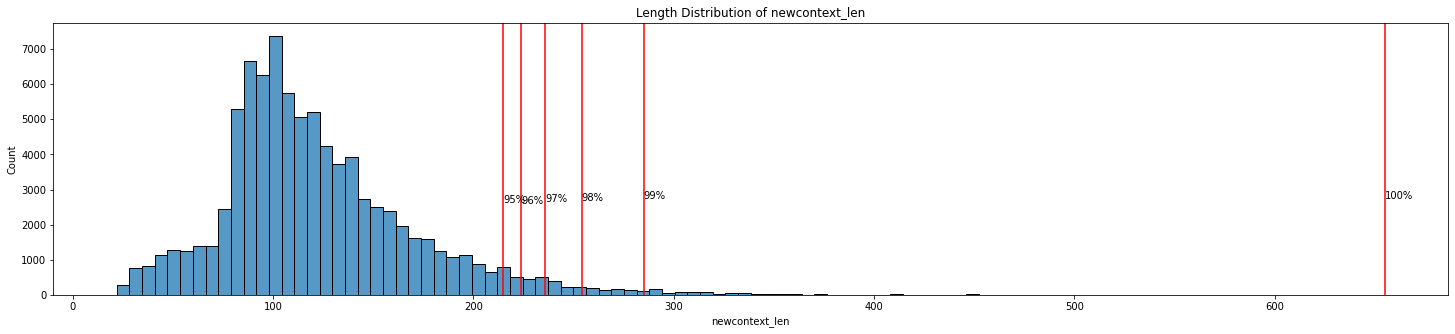

In [40]:
dist_info(df['newcontext_len'], (95,100))


In Order to Cover 100 percent of the data we need to create input length of 653 words which is too much. 

In [41]:
context_input_len = 1000 + 2 # +2 for <SOS> AND <EOS>

In [42]:
# Unique words in  context
# all_words = [i.split() for i in df['newcontext']]

## 2. Questions

In [43]:
df['question_len'].max()

25601

Percent  ::   words  

    95%  ::   17.0 words
    96%  ::   17.0 words
    97%  ::   18.0 words
    98%  ::   19.0 words
    99%  ::   21.0 words


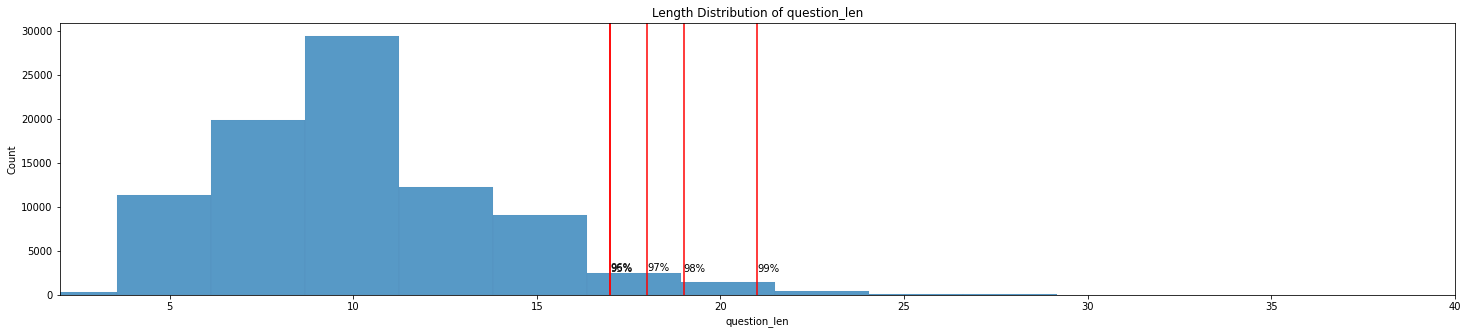

In [44]:
dist_info(x = df['question_len'], r = (95,99), xlim=[2,40], bins = 10000)

clearly there are too much bins 

Similar to context , for input for questions we would go with 50 words , it covers 99% data 

In [45]:
question_inputs_len = 50 + 2 # for <SOS> AND <EOS>

## 3. Answers

Percent  ::   words  

    95%  ::   10.0 words
    96%  ::   11.0 words
    97%  ::   13.0 words
    98%  ::   15.0 words
    99%  ::   18.0 words
   100%  ::   43.0 words


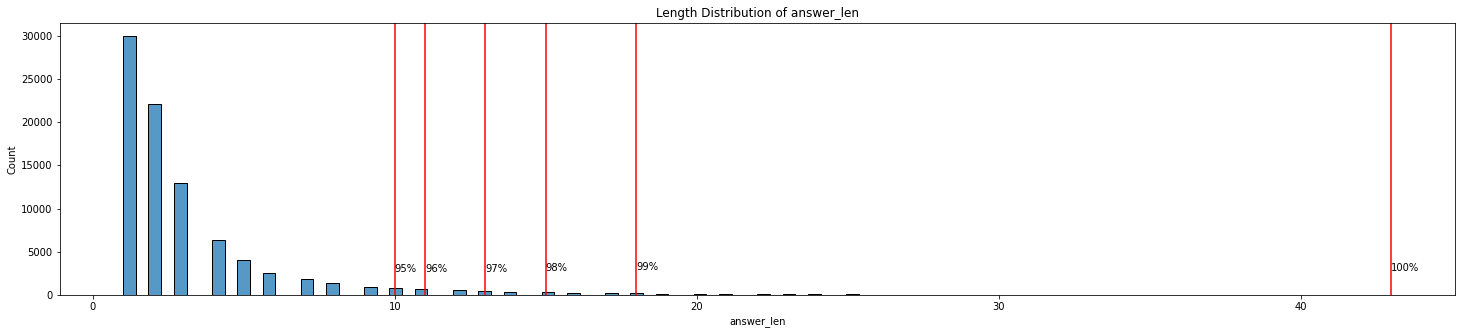

In [46]:
dist_info(df['answer_len'], (95,100))


Similar to context , for input for answers we would go with 50 words , it covers 100% data 

In [47]:
answer_inputs_len = 50 + 2 # for <SOS> AND <EOS>

# Preprocessing TEXT

In [48]:
# FUNCTIONS TO EXPAND CONTRACTIONS

with open('contractions.json') as f:
   contractions_dict = json.load(f)

def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x


In [49]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard
def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    text = cont_to_exp(text)
    text = re.sub('[#,@,&]', '',text)
    text = re.sub("'s",'', text)
    text = text.replace("?",' ?')
    text = text.replace(".",' .')
    text = text.replace("!",' !')
    text = text.replace(",",' ,')

    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    return text

In [50]:
# func 1
df = df.with_columns([
    (pl.col("newcontext").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("questions").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("answer_text").apply(lambda x: text_cleaning_apos(x)))

])

In [51]:
df

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
0,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""when did beyon...","""[{'text': 'in ...",false,1,"""{'text': 'in t...","""in the late 19...",269,"""beyoncé beyonc...",109,111,6,4
1,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""what areas did...","""[{'text': 'sin...",false,1,"""{'text': 'sing...","""singing and da...",207,"""beyoncé beyonc...",109,111,11,3
2,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""when did beyon...","""[{'text': '200...",false,1,"""{'text': '2003...","""2003""",526,"""beyoncé beyonc...",109,111,11,1
3,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""in what city a...","""[{'text': 'Hou...",false,1,"""{'text': 'Hous...","""houston texas""",166,"""beyoncé beyonc...",109,111,11,2
4,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""in which decad...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""late 1990s""",276,"""beyoncé beyonc...",109,111,7,2
5,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""in what rb gro...","""[{'text': ""Des...",false,1,"""{'text': ""Dest...","""destiny child""",320,"""beyoncé beyonc...",109,111,9,2
6,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""what album mad...","""[{'text': 'Dan...",false,1,"""{'text': 'Dang...","""dangerously in...",505,"""beyoncé beyonc...",109,111,8,3
7,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""who managed th...","""[{'text': 'Mat...",false,1,"""{'text': 'Math...","""mathew knowles...",360,"""beyoncé beyonc...",109,111,6,2
8,"""Beyoncé""","""Beyoncé Gisell...","""56d43c5f2ccc5a...","""when did beyon...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""late 1990s""",276,"""beyoncé beyonc...",109,111,6,2


In [52]:
# Adding start and end tokens 
'''
<soc>  : start of context
<eoc>  : end of context

<soq>  : start of questions
<eoq>  : end of questions

<soa>  : start of answer
<eoa>  : end of answer
'''
df = df.with_columns([
    ('<SOC> ' + pl.col('newcontext') + ' <EOC>').alias('newcontext'),
    ('<SOQ> ' + pl.col('questions') + ' <EOQ>').alias('questions'),
    ('<SOA> ' + pl.col('answer_text') + ' <EOA>').alias('answer_text'),    
])

In [53]:
df

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
0,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""<SOQ> when did...","""[{'text': 'in ...",false,1,"""{'text': 'in t...","""<SOA> in the l...",269,"""<SOC> beyoncé ...",109,111,6,4
1,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""<SOQ> what are...","""[{'text': 'sin...",false,1,"""{'text': 'sing...","""<SOA> singing ...",207,"""<SOC> beyoncé ...",109,111,11,3
2,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""<SOQ> when did...","""[{'text': '200...",false,1,"""{'text': '2003...","""<SOA> 2003 <EO...",526,"""<SOC> beyoncé ...",109,111,11,1
3,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""<SOQ> in what ...","""[{'text': 'Hou...",false,1,"""{'text': 'Hous...","""<SOA> houston ...",166,"""<SOC> beyoncé ...",109,111,11,2
4,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""<SOQ> in which...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""<SOA> late 199...",276,"""<SOC> beyoncé ...",109,111,7,2
5,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""<SOQ> in what ...","""[{'text': ""Des...",false,1,"""{'text': ""Dest...","""<SOA> destiny ...",320,"""<SOC> beyoncé ...",109,111,9,2
6,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""<SOQ> what alb...","""[{'text': 'Dan...",false,1,"""{'text': 'Dang...","""<SOA> dangerou...",505,"""<SOC> beyoncé ...",109,111,8,3
7,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""<SOQ> who mana...","""[{'text': 'Mat...",false,1,"""{'text': 'Math...","""<SOA> mathew k...",360,"""<SOC> beyoncé ...",109,111,6,2
8,"""Beyoncé""","""Beyoncé Gisell...","""56d43c5f2ccc5a...","""<SOQ> when did...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""<SOA> late 199...",276,"""<SOC> beyoncé ...",109,111,6,2


# Vectorization

In [54]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [ ]:
# we will be using universal sentence encoder for vectorization and embedding
download_USEncoder() # safety

downloading universal sentence encoder...
--2023-01-26 10:38:55--  https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 142.251.163.128, 142.251.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960367946 (916M) [application/x-tar]
Saving to: ‘4.tar.gz.1’

4.tar.gz.1          100%[===================>] 915.88M   177MB/s    in 5.0s    

2023-01-26 10:39:00 (182 MB/s) - ‘4.tar.gz.1’ saved [960367946/960367946]

Downloaded universal sentence encoder.
mkdir: cannot create directory ‘universal_sentence_encoder’: File exists
Extracting universal sentence encoder....
Extracted.


In [ ]:
embed = hub.KerasLayer("./universal_sentence_encoder")

> **Note:** when using Univesal sentence encoder a == A but <a\> != a . This means `use` does not strip signs. GOOD NEWS

In [ ]:

Sentences = [
    '<a>', 'a', 'A',            
    "How <old> are you",
    "What is your age",
    "I love to watch Television",
    "I am wearing a wrist watch"
]
text_vectorizer = TextVectorization(max_tokens=30)
text_vectorizer.adapt(Sentences)
vect_layer = text_vectorizer(Sentences)
print(vect_layer)

embeddings = embed(Sentences)
  
print('senetence embedding',embeddings)


tf.Tensor(
[[ 2  0  0  0  0  0]
 [ 2  0  0  0  0  0]
 [ 2  0  0  0  0  0]
 [15 12 16  6  0  0]
 [ 8 14  5 18  0  0]
 [ 4 13 10  3 11  0]
 [ 4 17  9  2  7  3]], shape=(7, 6), dtype=int64)
senetence embedding tf.Tensor(
[[ 0.03134873 -0.03212241 -0.02605016 ... -0.05512378  0.01821145
  -0.0629246 ]
 [-0.03478366 -0.06121081  0.01487271 ... -0.08291933  0.02704698
   0.02225077]
 [-0.03478366 -0.06121081  0.01487271 ... -0.08291933  0.02704698
   0.02225077]
 ...
 [-0.08415681 -0.08687922  0.03446117 ... -0.01439389 -0.04546221
   0.03639964]
 [ 0.0816019  -0.01570276 -0.05659244 ... -0.07133698  0.11040761
  -0.0071095 ]
 [-0.00369537  0.03064634 -0.05556112 ...  0.01751421  0.03164959
  -0.05139377]], shape=(7, 512), dtype=float32)


# Preparing Dataset using `tf.data` api

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain , xtest, ytrain, ytest = train_test_split(df[['newcontext', 'questions']], df['final_answer'], test_size = .02, random_state = 5)
xtrain , xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = .02, random_state = 5)

In [ ]:
print(f'Xtrain: {xtrain.shape} :: ytrain: {ytrain.shape}')
print(f'Xval:   {xval.shape}  :: yval: {yval.shape}')
print(f'Xtest:  {xtest.shape}  :: ytest: {ytest.shape}')

Xtrain: (83382, 2) :: ytrain: (83382,)
Xval:   (1702, 2)  :: yval: (1702,)
Xtest:  (1737, 2)  :: ytest: (1737,)


In [ ]:
# Train data
train_feat = tf.data.Dataset.from_tensor_slices((xtrain['newcontext'].to_list(), xtrain['questions'].to_list()))
train_response = tf.data.Dataset.from_tensor_slices((ytrain))
train_data = tf.data.Dataset.zip((train_feat, train_response))

# Test data
test_feat = tf.data.Dataset.from_tensor_slices((xtest['newcontext'].to_list(), xtest['questions'].to_list()))
test_response = tf.data.Dataset.from_tensor_slices((ytest))
test_data = tf.data.Dataset.zip((test_feat, test_response))

# Val data
val_feat = tf.data.Dataset.from_tensor_slices((xval['newcontext'].to_list(), xval['questions'].to_list()))
val_response = tf.data.Dataset.from_tensor_slices((yval))
val_data = tf.data.Dataset.zip((val_feat, val_response))

In [ ]:
BATCH_SIZE = 32

# prefetching 
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [ ]:
# preprocessing text
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

# Adding start and end tokens 
'''
<soc>  : start of context
<eoc>  : end of context

<soq>  : start of questions
<eoq>  : end of questions

<soa>  : start of answer
<eoa>  : end of answer
'''
# df = df.with_columns([
#     ('<soc> ' + pl.col('newcontext') + ' <eoc>').alias('newcontext'),
#     ('<soq> ' + pl.col('questions') + ' <eoq>').alias('questions'),
#     ('<soa> ' + pl.col('final_answer') + ' <eoa>').alias('final_answer'),    
# ])

In [ ]:
for row in train_data.take(1):
  print(row)


((<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"<soc> Labour_Party_(UK)  Blair announced in September 2006 that he would quit as leader within the year, though he had been under pressure to quit earlier than May 2007 in order to get a new leader in place before the May elections which were expected to be disastrous for Labour. In the event, the party did lose power in Scotland to a minority Scottish National Party government at the 2007 elections and, shortly after this, Blair resigned as Prime Minister and was replaced by his Chancellor, Gordon Brown. Although the party experienced a brief rise in the polls after this, its popularity soon slumped to its lowest level since the days of Michael Foot. During May 2008, Labour suffered heavy defeats in the London mayoral election, local elections and the loss in the Crewe and Nantwich by-election, culminating in the party registering its worst ever opinion poll result since records began in 1943, of 23%, with many citing Brown's le

# Model

In [ ]:
# # step 1
# context_inputs = layers.Input(shape = [], dtype = tf.string, name= 'context_inputs')
# use_layer = embed(context_inputs)
# token_outputs = layers.Dense(128, activation = 'relu')(use_layer)

# token_model = keras.Model(inputs = context_inputs, outputs = token_outputs)

# # step 2
# char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = 'char_inputs')
# char_em = embed(char_vector)
# char_outputs = layers.Bidirectional(layers.LSTM(24))(char_em)

# char_model = keras.Model(inputs = char_inputs, outputs = char_outputs)

# #step 3

# combined_layer = layers.Concatenate(name = 'combined_layer')([token_model.output, char_model.output])

# # step 4
# x = layers.Dropout(.5)(combined_layer)
# x = layers.Dense(128, activation = 'relu')(x)
# x = layers.Dropout(.5)(x)
# final_outputs = layers.Dense(5, activation = 'softmax')(x)

# # step 5
# model4 = keras.Model(inputs = [token_inputs, char_inputs], outputs = final_outputs, 
#                      name = 'model4_hybrid_inputs')

In [ ]:
UNITS = 32
output_dim =512 # universal sentence encoder embeddes is 512 many dimensions

# Define the encoder
encoder_inputs = Input(shape = [], dtype = tf.string, name= 'context_inputs')
print(encoder_inputs.shape)
embed_layer1 = embed(encoder_inputs)
embed_layer1 = tf.expand_dims(embed_layer1, axis = 1)

print(embed_layer1.shape)
encoder = LSTM(UNITS, return_state=True)

encoder_outputs, state_h, state_c = encoder(embed_layer1)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape = [], dtype = tf.string, name= 'question_inputs')
embed_layer2 = embed(decoder_inputs)
embed_layer2 = tf.expand_dims(embed_layer2, axis = 1)


decoder_lstm = LSTM( UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(embed_layer2, initial_state=encoder_states)
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(attention)

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile and fit the model
model.compile(optimizer='adam', loss='categorical_crossentropy')


(None,)
(None, 1, 512)


In [ ]:
EPOCHS = 2

In [ ]:
model.fit(train_data, epochs=EPOCHS)